In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from random import choice
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from skimage.transform import resize
from scipy.stats import norm
import tensorflow as tf
from utils import *
from random import shuffle

#from tensorflow.contrib import layers

/home/josh/anaconda3/envs/py3_tf16/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from generator import DataGenerator as gen

# For training (WILL bin steering annos, and WILL normalize throttle)           
# Images are normalized                                                         
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
#from generator import preprocess_normalize_images_bin_annos as process_fn       
#from generator import prepare_batch_images_and_labels_RAND_MIRROR as prep_batch 
                                                                                
# For evaluation (will NOT bin steering annos, and will leave throttle 0-1024)  
# Images are normalized                                                         
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
from generator import preprocess_normalize_images_only as process_fn           
from generator import prepare_batch_images_and_labels_NO_MIRROR as prep_batch

base_dir      = '../data/clr_120_160/'
image_dir     = base_dir + 'images/'
anno_dir      = base_dir + 'annotations/'
test_path  = '../data/evened_test.txt'

raw_test = load_dataset(test_path)

test_gen=gen(batch_size=10, 
             data_set=raw_test[:500],
             image_dir=image_dir,
             anno_dir=anno_dir,
             preprocess_fn=process_fn,
             prepare_batch_fn=prep_batch)

Loading Data: 100%|██████████| 500/500 [00:00<00:00, 1068.71it/s]


### Perform Prediction on images using ONLY test data


In [5]:
## MAKE SURE YOU LOAD THE CORRECT MODULE

import base_module as model
from load_frozen import load_graph

# SUPER JANK!!! This should be defined in the model
def prepare_data(generator):
    batch    = generator.get_next_batch()
    images   = batch["images"]
    steering = [ele["steering"] for ele in batch["annotations"]]
    throttle = [ele["throttle"] for ele in batch["annotations"]]
    return images, steering, throttle


test_gen.reset()                                               
t_test = trange(test_gen.steps_per_epoch)                     
t_test.set_description(f": Poop")

# Load frozen graph
# ========================================================
root_zeus = "/media/silverpond/development/home/josh/repos/FYP/fyp_diy_robo_car/modular_networks"
root_local = "/home/jp/Documents/FYP/ml/modular_networks/__z__"

# Loacl nns
test = root_local + "/__z__"

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Zeus nns
vae_b5_300 = "/vae_b5_steering"
vae_b1_300 = "/vae_b1_steering_ep100"
autoenc    = "/autoenc_steering_ep100"
vae_1_st_ep100_3den = "/vae_1_steering_ep100_3dense"
vae_1_st_ep100_4den = "/vae_1_steering_ep100_4dense"
world_vae_b1_z50    = "/world_vae_b1_z50_steering"
noisy_vae           = "/noisy_world_vae_b1"
# ========================================================
root = root_zeus
path = root + noisy_vae

frozen_graph_path  = path+"/frozen.pb"
tensor_lookup_path = path+"/tensor_names.json"
tensor_lookup = json.load(open(tensor_lookup_path, 'r'))

#frozen_graph_path = return_info["frozen_meta"]
#tensor_lookup = json.load(open(return_info["tensor_json"]))

prefix = "model"
graph = load_graph(frozen_graph_path, prefix)
x_tens        = graph.get_tensor_by_name(prefix+"/"+tensor_lookup[model.INPUTS][model.IMAGE_INPUT])
prediction_tens = graph.get_tensor_by_name(prefix+"/"+tensor_lookup[model.OUTPUTS][model.PREDICTION])

GPU_OPTIONS = tf.GPUOptions(per_process_gpu_memory_fraction=2/11)
with tf.Session(graph=graph, config=tf.ConfigProto(gpu_options=GPU_OPTIONS)) as sess:

    control = {"preds" : [], "annos" : []}
    for step in t_test:                       
        images, st_annos, th_annos = prepare_data(test_gen)
        prediction = sess.run(prediction_tens, feed_dict={x_tens: images})
        control["preds"].extend(prediction*(1024/15))
        control["annos"].extend(st_annos)
#         control["preds"].extend(prediction)
#         control["annos"].extend([x//68 for x in st_annos])


: Poop:   0%|          | 0/50 [00:00<?, ?it/s]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/josh/anaconda3/envs/py3_tf16/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/josh/anaconda3/envs/py3_tf16/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/josh/anaconda3/envs/py3_tf16/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

: Poop: 100%|██████████| 50/50 [00:01<00:00, 25.16it/s]


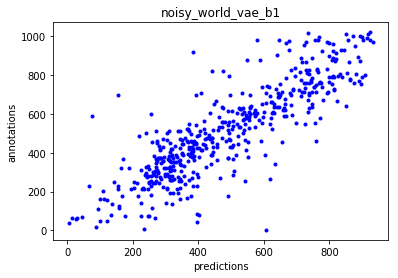

In [6]:
plt.plot(control["preds"], control["annos"], 'b.')
plt.xlabel("predictions")
plt.ylabel("annotations")
plt.title(os.path.split(path)[-1])
fig = plt.gcf()
fig.savefig(path + "/pred_vs_anno.png", dpi=100)

# Time Series tracking

Text(0.5,0,'steering command')

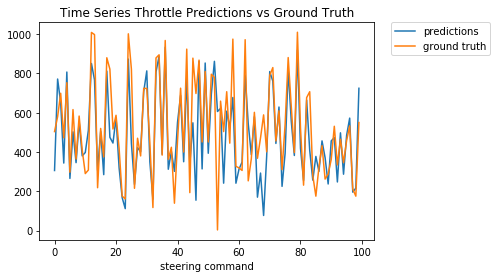

In [7]:
start = 0
end  = start + 100
plt.plot(control["preds"][start:end], label="predictions")
plt.plot(control["annos"][start:end], label="ground truth")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Time Series Throttle Predictions vs Ground Truth")
plt.xlabel("time (frames)")
plt.xlabel("steering command")

Text(0.5,0,'steering command')

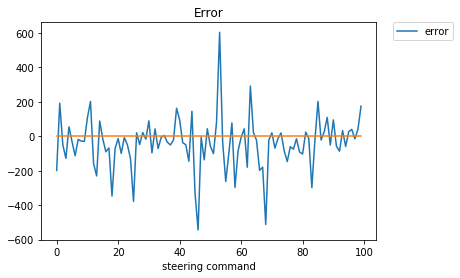

In [8]:
start = 0
window = 100
end  = start + window
plt.plot(np.array(control["preds"][start:end])-np.array(control["annos"][start:end]), label="error")
plt.plot(range(start, end), np.zeros(window))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Error")
plt.xlabel("time (frames)")
plt.xlabel("steering command")